In [2]:
import sys
import os
import pandas as pd
import numpy as np
import pymc

sys.path.append(f'{os.path.dirname(os.path.dirname(os.getcwd()))}/draft_pick_prob')

In [3]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv')
draft_df = pd.read_csv('2021_draft_order.csv', encoding='ISO-8859-1')

'''
mock_draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_SW_jun22_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_SW_21'})
mock_draft_df_2=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PW_jun21_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_PW_21'})
mock_draft_df_3=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_CP_jun15_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP_21'})
mock_draft_df_4=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_CP_md.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_2CP_21'})
mock_draft_df_5=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_3CP_md.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_3CP_21'})
mock_draft_df_6=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_4CP_md.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_4CP_21'})
mock_draft_df_7=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_5CP_md.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_5CP_21'})
'''

possible_players=pd.read_csv('2021_PLAYER_IDS.csv',encoding='ISO-8859-1')
possible_players

,PLAYER_NAME,PLAYER_ID
0,Owen Power,1
1,Matty Beniers,2
2,Mason McTavish,3
3,Luke Hughes,4
4,Kent Johnson,5
...,...,...
255,Jeremy Wilmer,255
256,Trevor Wong,256
257,Kalle Ervasti,257
258,Luke Mittelstadt,258


In [4]:
file_list =['2021_SW_jun22_bb.csv','2021_PW_jun21_bb.csv','2021_CP_jun15_bb.csv','2021_CP_md.csv','2021_3CP_md.csv','2021_4CP_md.csv','2021_5CP_md.csv']

mock_draft_dfs = []


for filename in file_list:
    df = pd.read_csv(filename)  # Read the CSV file
    
    # Sort the DataFrame by 'RANK' column
    df = df.sort_values(by='RANK')
    
    
    prefix = filename[5:7]
        
    # Rename the 'RANK' column based on the extracted prefix
    if filename[-6:-4]== 'bb':
        df = df.rename(columns={'RANK': f'bb_RANK_{prefix}_21'})
    else:
        df = df.rename(columns={'RANK': f'md_RANK_{prefix}_21'})
    
    mock_draft_dfs.append(df)  # Add the processed DataFrame to the list



#possible_players=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv')
#draft_df
#possible_players



In [5]:
import math
df_player_rankings=possible_players[['PLAYER_ID']].merge(mock_draft_dfs[0][['PLAYER_ID','bb_RANK_SW_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[1][['PLAYER_ID','bb_RANK_PW_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[2][['PLAYER_ID','bb_RANK_CP_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[3][['PLAYER_ID','md_RANK_CP_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[4][['PLAYER_ID','md_RANK_3C_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[5][['PLAYER_ID','md_RANK_4C_21']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[6][['PLAYER_ID','md_RANK_5C_21']], how='left', on=['PLAYER_ID'])



df_player_rankings


,PLAYER_ID,bb_RANK_SW_21,bb_RANK_PW_21,bb_RANK_CP_21,md_RANK_CP_21,md_RANK_3C_21,md_RANK_4C_21,md_RANK_5C_21
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,4.0,2.0,5.0,2.0,2.0,2.0,2.0
2,3,10.0,7.0,9.0,6.0,6.0,9.0,6.0
3,4,7.0,6.0,4.0,4.0,4.0,4.0,4.0
4,5,2.0,9.0,6.0,9.0,9.0,8.0,7.0
...,...,...,...,...,...,...,...,...
255,255,73.0,NaN,NaN,NaN,NaN,NaN,NaN
256,256,81.0,NaN,NaN,NaN,NaN,NaN,NaN
257,257,87.0,NaN,NaN,NaN,NaN,NaN,NaN
258,258,97.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def likelihood(strengths, rankings):
    # params: vector of parameters [intercept, slope]
    likelihood=1
    counter=1
    paired_lists = list(zip(strengths, rankings))
    sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    while counter<len(sorted_list2)+1 and sorted_list2[counter]!=sorted_list2[counter+1]:

        likelihood+=np.log(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        counter+=1
    return likelihood

def neg_log_likelihood(params, df):
    neg_ll = 1  # Initialize as 0 for correct accumulation
    columns_to_go_through = df.columns[1:]
    for i in columns_to_go_through:
        max_rank = df[i].max() + 1
        player_rank = list(df[i])
        fixed_player_rank = [max_rank if math.isnan(x) else x for x in player_rank]
        
        # Determine the weighting factor based on column name
        if i.startswith('bb'):
            weight = 0.5  # Example: 0.5 for less value
        elif i.startswith('md'):
            weight = 1.0  # Example: 1.0 (or more) for 'md' columns
        else:
            weight = 1.0  # Default weight for other columns

        # Apply the weighting factor
        neg_ll -= weight * likelihood(params, fixed_player_rank)

    return neg_ll

In [7]:
def constraint_eq(x):
    return sum(x)

In [8]:
import scipy.optimize

counter=40
l_play=[]
variable_bounds=[]
count=0

while count<len(df_player_rankings):
    l_play.append(counter)
    count+=1
    counter-=0.20
    variable_bounds.append((-40,40))

result = scipy.optimize.minimize(neg_log_likelihood, l_play, args=(df_player_rankings,), method='SLSQP', bounds=variable_bounds, constraints={'type': 'eq', 'fun': constraint_eq})
print(result.x)

[ 4.00000000e+01  2.97496194e+01  2.55448833e+01  2.77236835e+01
  2.50846757e+01  2.57289000e+01  2.58152325e+01  2.55646781e+01
  2.86691399e+01  1.56231231e+01  2.22451708e+01  2.14940751e+01
  1.90896554e+01  2.12320978e+01  2.05278812e+01  1.90698545e+01
  2.27749242e+01  1.98306251e+01  2.20271867e+01  1.96460938e+01
  1.89043880e+01  1.73593866e+01  1.66588482e+01  2.04591334e+01
  2.07110382e+01  1.72276486e+01  1.86743303e+01  1.49524942e+01
  1.65690982e+01 -5.57865939e+00  1.26177685e+01  1.61191595e+01
  1.66919954e+01 -1.99279896e+00  1.50530229e+01  1.48556614e+00
  1.76925348e+01  1.68243355e+00  1.30917439e+01  1.44989312e+01
  1.71751913e+01  1.34804897e+01  1.49538870e+01  1.48913120e+01
  1.72811949e+01  1.72155981e+01  1.34330079e+01  1.63544591e+00
  1.97102925e+01  1.47201174e+01  1.94691910e+01  1.59362024e+01
  1.59235071e+01  1.22550303e+01  1.55705132e+01  1.55938982e+01
  1.34705791e+01  1.43672266e+01  1.54351979e+00  1.57445833e+01
  1.45688055e+01  1.45808

In [9]:
player_ability_parameters_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_PLAYER_IDS.csv', encoding='ISO-8859-1')
player_ability_parameters_df['ABILITY_PARAMS']=result.x
player_ability_parameters_df=player_ability_parameters_df.sort_values(by='ABILITY_PARAMS', ascending=False, axis=0)
player_ability_parameters_df['SIM_RANK'] = range(1, len(player_ability_parameters_df) + 1)
player_ability_parameters_df.head(10)


,PLAYER_NAME,PLAYER_ID,ABILITY_PARAMS,SIM_RANK
0,Owen Power,1,40.000000,1
1,Matty Beniers,2,29.749619,2
8,Dylan Guenther,9,28.669140,3
3,Luke Hughes,4,27.723683,4
6,William Eklund,7,25.815232,5
5,Simon Edvinsson,6,25.728900,6
7,Brandt Clarke,8,25.564678,7
2,Mason McTavish,3,25.544883,8
4,Kent Johnson,5,25.084676,9
16,Chaz Lucius,18,22.774924,10


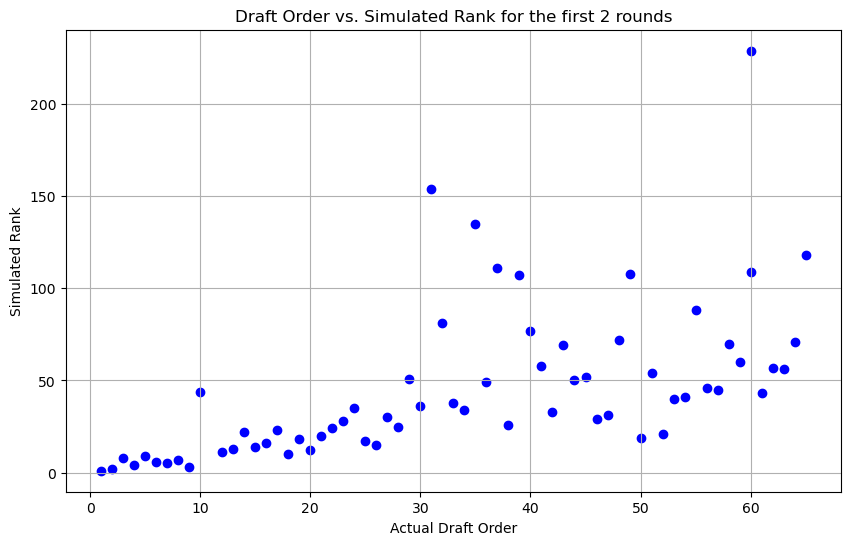

In [10]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')
merged_df
# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)


plt.show()



In [11]:
#Error -Mean absolute error (MAE)
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_NAME', 'ORDER']], on='PLAYER_NAME')
merged_df = merged_df.sort_values(by='ORDER')
merged_df = merged_df.head(32)
merged_df['ERROR'] = abs(merged_df['SIM_RANK']-merged_df['ORDER'])
mae = merged_df['ERROR'].sum()/len(merged_df['ERROR'])
print(mae)


# (-40,40 bounds gives 10.03 mae with 0.2 for bb and 1 for md)
# (-40,40 bounds gives 10.19 mae with 0.5 for bb and 1 for md)
# (-40,40 bounds gives 12.97 mae with .8 for bb and 1 for md)
# (-40,40 bounds gives 13.875 mae with 1 for bb and 1 for md)



10.1875


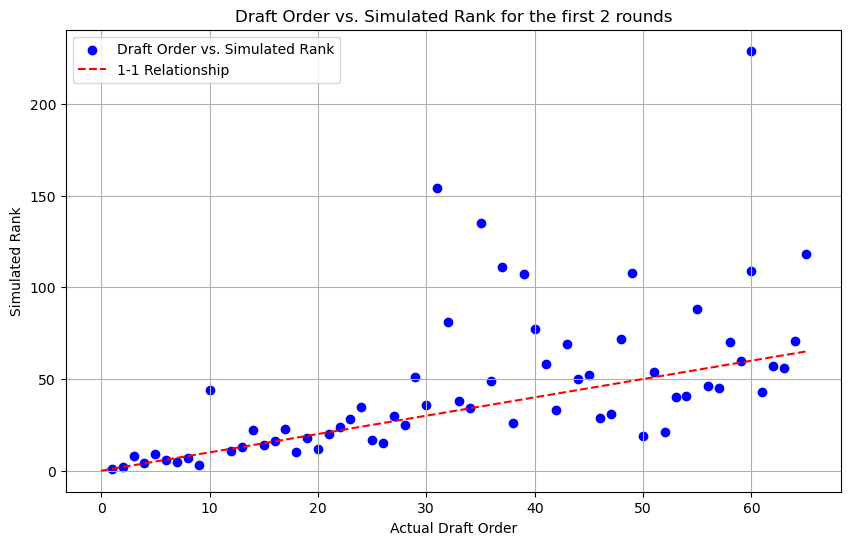

In [12]:
#plot with line on it 
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')

# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.plot([0, merged_df_first_100['ORDER'].max()], [0, merged_df_first_100['ORDER'].max()], c='red', linestyle='--', label='1-1 Relationship')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)

plt.legend()
plt.show()
